In [1]:
# Generates simulated data 
 
# Modified from Emilio Andreozzi "Phenomenological models of NaV1.5.
    # A side by side, procedural, hands-on comparison between
    # Hodgkin-Huxley and kinetic formalisms." 2019
# Emily Nguyen
 
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy import optimize, stats
h.dt = 0.025
##################
# Activation Na 1.2 
##################e
 
# Args: String command
# Calls activationNa12 plotting function when command == "plotActivation"
# Calls activationNa12 data generating function when command == "genActivation"
# genActivation Returns vector for peak currents (NOT normalized)

# default args:
# str channel_name : name of channel to insert, default 
# x_axis_min : lower bound for x-axis
# x_axis_max : upper bound for x_axis
# x_axis_step : xticks

# one compartment cell
# soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, 
# channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025

# clamping params
# dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120

# a electrode voltage clamp ## not all nums included
# f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120

# for plotting
# x_axis_min=-100, x_axis_max=40, x_axis_step=10

def activationNa12(command, \
                  soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                  channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                  dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                  f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120, \
                  x_axis_min=-100, x_axis_max=40, x_axis_step=10):
 
    dtype = np.float64
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
     
    soma.diam   = soma_diam        # micron
    soma.L      = soma_L  # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg         # adimensional
    soma.cm     = soma_cm         # uF/cm2
    soma.Ra     = soma_Ra       # ohm-cm
 
    soma.insert(channel_name)     #insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius        # temperature in celsius
    v_init      = v_init      # holding potential
    h.dt        = h_dt      # ms - value of the fundamental integration time step, dt, used by fadvance().
 
    # clamping parameters
    dur         = dur       # clamp duration, ms
    step        = step         # voltage clamp increment, the user can 
    st_cl       = st_cl       # clamp start, mV 
    end_cl      = end_cl        # clamp end, mV
    v_cl        = v_cl       # actual voltage clamp, mV 
 
    # a electrode voltage clamp
    f3cl = h.VClamp(soma(0.5))
    f3cl.dur[0] = f3cl_dur0      # ms 
    f3cl.amp[0] = f3cl_amp0    # mV 
    f3cl.dur[1] = dur     # ms
    f3cl.amp[1] = v_cl    # mV
    f3cl.dur[2] = f3cl_dur2      # ms 
    f3cl.amp[2] = f3cl_amp2    # mV 
 
    #number of elements of the vector containing the values from st_cl to end_cl with the fixed step
    L=len(np.arange(st_cl, end_cl, step))
 
    # vectors for data handling
    t_vec       = h.Vector()  # vector for time
    v_vec       = h.Vector()  # vector for voltage
    v_vec_t     = h.Vector()  # vector for voltage as function of time
    i_vec       = h.Vector()  # vector for current 
    ipeak_vec   = h.Vector()  # vector for peak current
    gpeak_vec   = h.Vector()  # vector for peak conductance
    gnorm_vec   = h.Vector()  # vector for normalized conductance
    all_is = []
 
    # clamping definition
    def clamp(v_cl):
 
        curr_tr = 0  # initialization of peak current
        cond_tr = 0  # initialization of peak conductance
 
        h.finitialize(v_init) # calling the INITIAL block of the mechanism inserted in the section.
 
        # initialization of variables used to commute the peak current and conductance    
        pre_i  = 0    
        dens   = 0
 
        f3cl.amp[1] = v_cl    # mV
 
        for j in range(30):
 
            while (h.t<h.tstop): # runs a single trace, calculates peak current
                dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
 
                t_vec.append(h.t)       # code for storing the current
                v_vec_t.append(soma.v)  # trace to be plotted
                i_vec.append(dens)      # trace to be plotted
 
                if ((h.t>5)and(h.t<=10)):       # evaluate the peak 
                    if(abs(dens)>abs(pre_i)):
                        cond_tr = soma.thegna_na12mut   # updates the peak conductance ### NEED TO CHANGE NAME IF CHANGE MOD FILE NAME
                        curr_tr = dens          # updates the peak current
 
                h.fadvance()
                pre_i = dens
 
        # updates the vectors at the end of the run        
        v_vec.append(v_cl)              
        gpeak_vec.append(cond_tr)
        ipeak_vec.append(curr_tr)
 
 
    ### start program and plots
    def plotActivation():
 
        # figure definition
        fig = plt.figure(figsize=(20,15))
        ax1 = plt.subplot2grid((2,4), (0, 0), colspan=2)
 
        fig.subplots_adjust(wspace=0.5)
 
        #ax1.set_xlim(-100,40) # default
        ax1.set_xticks(np.arange(x_axis_min, x_axis_max, step=x_axis_step))
        ax1.set_ylim(-0.05,1.05)        
        ax1.set_xlabel('Voltage $(mV)$')
        ax1.set_ylabel('Normalized conductance')
        ax1.set_title('Activation Na1.2: Voltage/Normalized conductance')
 
        h.tstop = 5 + dur + 5       # time stop
 
        # resizing the vectors
        v_vec.resize(0)          
        gpeak_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
                # resizing the vectors
                t_vec.resize(0)  
                i_vec.resize(0) 
                v_vec_t.resize(0) 
 
                clamp(v_cl)
                k=k+1
                all_is.append(i_vec)
 
        gpeak_max = gpeak_vec.max()           # maximum value of the conductance used to normalize the conductance vector
        for i in range(0, len(gpeak_vec), 1):
 
             gnorm_vec.append(gpeak_vec.x[i]/gpeak_max) # normalization of peak conductance
             ln2,=ax1.plot(v_vec.x[i], gnorm_vec.x[i], 'o', c='black')
 
        plt.show()
        return all_is
 
    # Generates simulated activation data
    # Returns peak current vector
    def genActivation():
        h.tstop = 5 + dur + 5       # time stop
 
        # resizing the vectors
        v_vec.resize(0)          
        gpeak_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
                # resizing the vectors
                t_vec.resize(0)  
                i_vec.resize(0) 
                v_vec_t.resize(0) 
 
        
                clamp(v_cl)
                k=k+1
                aa = i_vec.to_python()
                all_is.append(aa[1:])
 
        gpeak_max = gpeak_vec.max()           # maximum value of the conductance used to normalize the conductance vector
        for i in range(0, len(gpeak_vec), 1):
             gnorm_vec.append(gpeak_vec.x[i]/gpeak_max) # normalization of peak conductance
         
        return gnorm_vec, np.arange(st_cl, end_cl, step),all_is
 
    #Command Processor
    if command == "plotActivation":
        return plotActivation()
    elif command == "genActivation":
        return genActivation()
    elif command == "geth":
        return h
    else:
        print("Invalid command. Function does not exist.")
 
##################
# Inactivation Na 1.2 
##################
 
# Args: String command
# Calls inactivationNa12 plotting function when command == "plotInactivation"
# Calls inactivationNa12 data generating function when command == "genInactivation"
# genInactivation Returns vector for normalized current

# default args:
# str channel_name : name of channel to insert, default 
# x_axis_min : lower bound for x-axis
# x_axis_max : upper bound for x_axis
# x_axis_step : xticks

# one compartment cell
# soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, 
# channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025

# clamping params
# dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120

# a electrode voltage clamp ## not all nums included
# f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120

# for plotting
# x_axis_min=-100, x_axis_max=40, x_axis_step=10
def inactivationNa12(command, \
                    soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                    channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                    dur=500, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                    f3cl_dur0=40, f3cl_amp0=-120, f3cl_dur2=20, f3cl_amp2=-10, \
                    x_axis_min=-125, x_axis_max=40, x_axis_step=10):
    dtype = np.float64
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
    soma.diam   = soma_diam         # micron
    soma.L      = soma_L   # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg          # adimensional
    soma.cm     = soma_cm          # uF/cm2
    soma.Ra     = soma_Ra         # ohm-cm
 
    soma.insert(channel_name)      # insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius         # temperature in celsius
    v_init      = v_init       # holding potential   
    h.dt        = h_dt       # ms - value of the fundamental integration time step, dt, used by fadvance().
 
    # clamping parameters
    dur         = dur     # clamp duration, ms
    step        = step          # voltage clamp increment
    st_cl       = st_cl       # clamp start, mV
    end_cl      = end_cl          # clamp end, mV
    v_cl        = v_cl       # actual voltage clamp, mV
 
    #number of elements of the vector containing the values from st_cl to end_cl with the fixed step
    L=len(np.arange(st_cl, end_cl, step))
 
    # vectors for data handling
    t_vec       = h.Vector() # vector for time
    v_vec       = h.Vector() # vector for voltage
    v_vec_t     = h.Vector() # vector for voltage as function of time
    i_vec       = h.Vector() # vector for current 
    ipeak_vec   = h.Vector() # vector for peak current
    inorm_vec   = h.Vector() # vector for normalized current
 
    # a electrode voltage clamp
    f3cl = h.VClamp(soma(0.5))
    f3cl.dur[0] = f3cl_dur0         # ms
    f3cl.amp[0] = f3cl_amp0       # mV
    f3cl.dur[1] = dur        # ms
    f3cl.amp[1] = v_cl       # mV
    f3cl.dur[2] = f3cl_dur2         # ms
    f3cl.amp[2] = f3cl_amp2        # mV
    all_is=[]
    
    # clamping definition
    def clamp(v_cl):
 
        f3cl.amp[1] = v_cl
        h.finitialize(v_init)  # calling the INITIAL block of the mechanism inserted in the section.
 
        # parameters initialization
        peak_curr = 0
        dens = 0
        t_peak = 0
        dtsave = h.dt
       
        for j in range(30):
            
            while (h.t<h.tstop): # runs a single trace, calculates peak current
                if (h.t >537) or (h.t<40):
                    h.dt = dtsave
                else:
                    h.dt =1
                dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
                t_vec.append(h.t)       # code for store the current
                v_vec_t.append(soma.v)  # trace to be plotted
                i_vec.append(dens)      # trace to be plotted
                
                if ((h.t>=540)and(h.t<=542)):     # evaluate the peak (I know it is there)
                    if(abs(dens)>abs(peak_curr)):
                        peak_curr = dens        
                        t_peak = h.t
 
                h.fadvance()

            # updates the vectors at the end of the run        
        
        v_vec.append(v_cl)             
        ipeak_vec.append(peak_curr)
     ### start program and plots
    def plotInactivation():
 
        #figure definition
        fig = plt.figure(figsize=(20,15))
 
        ax5 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        #ax5.set_xlim(-125,40)
        ax5.set_xticks(np.arange(x_axis_min, x_axis_max, step=x_axis_step)) 
        ax5.set_ylim(-0.05,1.05)        
        ax5.set_xlabel('Voltage $(mV)$')
        ax5.set_ylabel('Normalized current')
        ax5.set_title('Inactivation Na1.2: Voltage/Normalized current relation')
 
 
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)
 
 
        h.tstop = 40 + dur + 20
        v_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter    
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
 
            # resizing the vectors
            t_vec.resize(0)
            i_vec.resize(0)
            v_vec_t.resize(0) 
 
            clamp(v_cl)
           
            # code for showing traces
            k=k+1
 
        ipeak_min = ipeak_vec.min()  # normalization of peak current with respect to the min since the values are negative
 
        for i in range(0, len(ipeak_vec), 1):
            inorm_vec.append(ipeak_vec.x[i]/ipeak_min)
            ln5,=ax5.plot(v_vec.x[i], inorm_vec.x[i], 'o', c="black")
 
        plt.show()
 
    # Generates simulated activation data
    # Returns vector for normalized current
    def genInactivation():
        h.tstop = 40 + dur + 20
        v_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter    
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
            # resizing the vectors
            t_vec.resize(0)
            i_vec.resize(0)
            v_vec_t.resize(0) 
 
            clamp(v_cl)
            aa = i_vec.to_python()
            all_is.append(aa[1:])
            
            #plt.plot(aa[1:])
            
            k=k+1
        #ipeak_vec = ipeak_vec.to_numpy()
        tmp = ipeak_vec.as_numpy()
        ipeak_min = ipeak_vec.min()  # normalization of peak current with respect to the min since the values are negative
        ii = [np.min(l) for l in all_is]
       # plt.show()
        for i in range(0, len(ipeak_vec), 1):
            inorm_vec.append(ipeak_vec.x[i]/ipeak_min)
             
        return inorm_vec, np.arange(st_cl, end_cl, step),all_is
 
    #Command Processor
    if command == "plotInactivation":
        return plotInactivation()
    elif command == "genInactivation":
        return genInactivation()
    else:
        print("Invalid command. Function does not exist.")
 
##################
# Recovery from Inactivation (RFI) &  RFI Tau Na 1.2 
##################
 
# Args: String command
# Plots recovery from inactivation when command == "plotRecInact"
# Calls recInactTauNa12 data generating function when command == "genRecInactTau"
# returns recovery vector and log time vector when command == "genRecInactTauCurve"
# plots Recovery of Inactivation time/voltage relation when command == "plotRecInactProcedure"
# Generates recovery from inactivation data when command == "genRecInact"

# default args:
# ntrials : number of trials ntrials=30
# recordTime=500
# str channel_name : name of channel to insert, default 

# one compartment cell
# soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, 
# channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1

# clamping params for recInactTau
# min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1
# vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000]

# a voltage clamp with "five" levels for RecInactTau ## not all nums included
# f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120 

def recInactTauNa12(command, \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                   vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                   f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120):
    
    dtype = np.float64
 
    ntrials = ntrials
    recordTime = recordTime
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
    soma.diam   = soma_diam        # micron
    soma.L      = soma_L  # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg         # dimensionless
    soma.cm     = soma_cm         # uF/cm2
    soma.Ra     = soma_Ra       # ohm-cm    
 
    soma.insert(channel_name)     #insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius        # temperature in celsius
    v_init      = v_init      # holding potential
    h.dt        = h_dt       # ms - value of the fundamental integration time step, dt,
                                #used by fadvance() in RecInactTau. 
                                #Increase value to speed up recInactTau().
 
    # clamping parameters for RecInactTau
    min_inter    = min_inter      # pre-stimulus starting interval
    max_inter    = max_inter     # pre-stimulus endinging interval
    num_pts      = num_pts       # number of points in logaritmic scale
    cond_st_dur  = cond_st_dur     # conditioning stimulus duration
    res_pot      = res_pot     # resting potential
    dur          = dur
 
    # vector containing 'num_pts' values equispaced between log10(min_inter) and log10(max_inter)
    # for RecInactTau
    vec_pts = vec_pts
    #vec_pts = np.logspace(np.log10(min_inter), np.log10(max_inter), num=num_pts)
    L = len(vec_pts)
 
    # vectors for data handling RecInactTau
    rec_vec      = h.Vector()   
    time_vec     = h.Vector()   
    log_time_vec = h.Vector()   
    t_vec        = h.Vector()
    v_vec_t      = h.Vector()
    i_vec_t      = h.Vector()
    rec_inact_tau_vec = h.Vector()
 
    # voltage clamp with "five" levels for RecInactTau
    f3cl = h.VClamp_plus(soma(0.5))
    f3cl.dur[0] = f3cl_dur0              # ms
    f3cl.amp[0] = f3cl_amp0           # mV
    f3cl.dur[1] = cond_st_dur    # ms default 1000
    f3cl.amp[1] = f3cl_amp1          # mV
    f3cl.dur[2] = dur            # ms
    f3cl.amp[2] = res_pot        # mV default -120
    f3cl.dur[3] = f3cl_dur3             # ms
    f3cl.amp[3] = f3cl_amp3          # mV
    f3cl.dur[4] = f3cl_dur4              # ms
    f3cl.amp[4] = f3cl_amp4           # mV
 
 
    # clamping definition for RecInactTau
    def clampRecInactTau(dur): 
 
        f3cl.dur[2] = dur 
        h.tstop = 5 + 1000 + dur + 20 + 5 ### DO WE WANNA GENERALIZE THIS? ;-;
        h.finitialize(v_init)
 
        #variables initialization
        pre_i1 = 0
        pre_i2 = 0
        dens   = 0   
 
        peak_curr1 = 0    
        peak_curr2 = 0
 
 
        while (h.t<h.tstop): # runs a single trace, calculates peak current
 
            dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
            t_vec.append(h.t)      
            v_vec_t.append(soma.v) 
            i_vec_t.append(dens)
 
 
            if ((h.t>5)and(h.t<15)):       # evaluate the first peak
                if(pre_i1<abs(dens)):
                    peak_curr1=abs(dens)
                pre_i1=abs(dens)
 
 
            if ((h.t>(5+cond_st_dur+dur))and(h.t<(15+cond_st_dur+dur))):  # evaluate the second peak 
 
 
                if(pre_i2<abs(dens)):
                    peak_curr2=abs(dens)
                pre_i2=abs(dens)
 
            h.fadvance()
 
        # updates the vectors at the end of the run  
        time_vec.append(dur)
        log_time_vec.append(np.log10(dur))
        rec_vec.append(peak_curr2/peak_curr1)
 
        #calc tau using RF and tstop
        #append values to vector
        RF_t = peak_curr2/peak_curr1
        tau = -h.tstop / np.log(-RF_t + 1)
        rec_inact_tau_vec.append(tau)
 
    # start RecInact program and plot
    def plotRecInact():
 
        # figure definition
        fig = plt.figure(figsize=(18,16))
        ax5 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        # if time_vec is changed to see plot in not log time
        # then change xlim to (-150, 5 + cond_st_dur + max_inter + 20 + 5)
        #ax5.set_xlim(-1.1,1.1)
        #ax5.set_ylim(-0.1, 1.1)
        ax5.set_xlabel('Log(Time)')
        ax5.set_ylabel('Fractional recovery (P2/P1)')
        ax5.set_title('Log(Time)/Fractional recovery (P2/P1)')
       
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInactTau(dur) 
            k+=1
 
            #change log_time_vec to time_vec (ms) to see plot in not log time
            ln5=ax5.scatter(time_vec, rec_vec, c="black")
            ax5.set_xscale('log')
 
        plt.show()
 
    # Generate RecInactTau
    # Returns rec_inact_tau_vec
    def genRecInactTau():
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInactTau(dur)
            k+=1
            
        return rec_inact_tau_vec


    def genRecInactTauCurve():
        # figure definition
        recov = []
        times = []
 
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInactTau(dur) 
            k+=1

            recov.append(rec_vec.to_python()[0])
 
        return recov, vec_pts
 
        
    # Plot time/voltage relation (simulation) for RFI
    def plotRecInactProcedure():
 
       # figure definition
        fig = plt.figure(figsize=(18,6))
        ax0 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        ax0.set_xlim(-150, 5 + max_inter + 20 + 100)
        ax0.set_ylim(-121, 20)
        ax0.set_xlabel('Time $(ms)$')
        ax0.set_ylabel('Voltage $(mV)$')
        ax0.set_title('Time/Voltage Reltation')
 
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInactTau(dur) 
            k+=1
 
            ln5 =ax0.plot(t_vec, v_vec_t, c="black")
 
        plt.show()
    
    # Generate RFI data
    # Returns rec_vec
    def genRecInact():
        k=0 #counter
 
        rec_return = []
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
            
            clampRecInactTau(dur)

            rec_return.append(rec_vec.to_python()[0])
            k+=1

        return rec_return, vec_pts
    
     #Command Processor
    if command == "plotRecInact":
        return plotRecInact()
    elif command == "genRecInactTau":
        return genRecInactTau()
    elif command == "genRecInactTauCurve":
        return genRecInactTauCurve()
    elif command == "plotRecInactProcedure":
        return plotRecInactProcedure()
    elif command == "genRecInact":
        return genRecInact()
    else:
        print("Invalid command. Function does not exist.")
        
### ###
def recInact_dv_TauNa12(command, \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.01,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1, res_pot=-120, dur=0.1,\
                   vec_pts = np.linspace(-120,0,num=13),\
                   f3cl_dur0=50, f3cl_amp0=-120, f3cl_dur1=5, f3cl_amp1=0, f3cl_dur2=1, \
                   f3cl_dur3=5, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120):
    
    dtype = np.float64
 
    ntrials = ntrials
    recordTime = recordTime
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
    soma.diam   = soma_diam        # micron
    soma.L      = soma_L  # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg        # dimensionless
    soma.cm     = soma_cm         # uF/cm2
    soma.Ra     = soma_Ra        # ohm-cm

    soma.insert(channel_name)     # insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius        # temperature in celsius
    v_init      = v_init      # holding potential
    h.dt        = h_dt      # ms - value of the fundamental integration time step, dt,
                                #used by fadvance() in RecInactTau. 
                                #Increase value to speed up recInactTau().
 
    # clamping parameters for RecInactTau
    min_inter    = min_inter      # pre-stimulus starting interval
    max_inter    = max_inter     # pre-stimulus endinging interval
    num_pts      = num_pts       # number of points in logaritmic scale
    cond_st_dur  = cond_st_dur     # conditioning stimulus duration
    res_pot      = res_pot     # resting potential
    dur          = dur
 
    # vector containing 'num_pts' values equispaced between log10(min_inter) and log10(max_inter)
    # for RecInactTau
    #vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000]
    #vec_pts = np.logspace(np.log10(min_inter), np.log10(max_inter), num=num_pts)
    vec_pts = vec_pts
    L = len(vec_pts)
 
    # vectors for data handling RecInactTau
    rec_vec      = h.Vector()   
    time_vec     = h.Vector()   
    log_time_vec = h.Vector()   
    t_vec        = h.Vector()
    v_vec_t      = h.Vector()
    i_vec_t      = h.Vector()
    rec_inact_tau_vec = h.Vector()
 
    # voltage clamp with "five" levels for RecInactTau
    f3cl = h.VClamp_plus(soma(0.5))
    f3cl.dur[0] = f3cl_dur0              # ms
    f3cl.amp[0] = f3cl_amp0           # mV
    f3cl.dur[1] = f3cl_dur1    # ms prev 1000
    f3cl.amp[1] = f3cl_amp1          # mV
    f3cl.dur[2] = f3cl_dur2            # ms
    f3cl.amp[2] = res_pot        # mV -120
    f3cl.dur[3] = f3cl_dur3             # ms
    f3cl.amp[3] = f3cl_amp3          # mV
    f3cl.dur[4] = f3cl_dur4              # ms
    f3cl.amp[4] = f3cl_amp4           # mV
    
    all_is = []
 
    # clamping definition for RecInactTau
    def clampRecInact_dv_Tau(curr_amp): 
 
        f3cl.amp[2] = curr_amp 
        h.tstop = 50 + 5 + 1 + 5 + 5
        h.finitialize(v_init)
 
        #variables initialization
        pre_i1 = 0
        pre_i2 = 0
        dens   = 0   
 
        peak_curr1 = 0    
        peak_curr2 = 0
 
 
        while (h.t<h.tstop): # runs a single trace, calculates peak current
 
            dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
            t_vec.append(h.t)      
            v_vec_t.append(soma.v) 
            i_vec_t.append(dens)
 
 
            if ((h.t>5)and(h.t<15)):       # evaluate the first peak
                if(pre_i1<abs(dens)):
                    peak_curr1=abs(dens)
                pre_i1=abs(dens)
 
 
            if ((h.t>(5+cond_st_dur+dur))and(h.t<(15+cond_st_dur+dur))):  # evaluate the second peak 
 
 
                if(pre_i2<abs(dens)):
                    peak_curr2=abs(dens)
                pre_i2=abs(dens)
                
            h.fadvance()
 
        # updates the vectors at the end of the run  
        time_vec.append(dur)
        log_time_vec.append(np.log10(dur))
        rec_vec.append(peak_curr2/peak_curr1)
 
        #calc tau using RF and tstop
        #append values to vector
        RF_t = peak_curr2/peak_curr1
        tau = -h.tstop / np.log(-RF_t + 1)
        rec_inact_tau_vec.append(tau)
 
    # start RecInact program and plot
    def plotRecInact_dv():
 
        # figure definition
        fig = plt.figure(figsize=(18,16))
        ax5 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        # if time_vec is changed to see plot in not log time
        # then change xlim to (-150, 5 + cond_st_dur + max_inter + 20 + 5)
        #ax5.set_xlim(-1.1,1.1)
        #ax5.set_ylim(-0.1, 1.1)
        ax5.set_xlabel('Log(Time)')
        ax5.set_ylabel('Fractional recovery (P2/P1)')
        ax5.set_title('Log(Time)/Fractional recovery (P2/P1)')
       
        k=0 #counter
 
        for amp in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInact_dv_Tau(amp) 
            k+=1
            
            #change log_time_vec to time_vec (ms) to see plot in not log time
            ln5=ax5.scatter(time_vec, rec_vec, c="black")
            ax5.set_xscale('log')
 
        plt.show()
 
    # Generate RecInactTau
    # Returns rec_inact_tau_vec
    def genRecInactTau_dv():
        k=0 #counter
 
        for amp in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInact_dv_Tau(amp)
            k+=1
            aa = i_vec_t.to_python()
            all_is.append(aa[1:])
        return rec_inact_tau_vec,all_is


    def genRecInactTauCurve_dv():
        # figure definition
        recov = []
        times = []
 
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInact_dv_Tau(dur) 
            k+=1

            recov.append(rec_vec.to_python()[0])
 
        return recov, vec_pts
 
        
    # Plot time/voltage relation (simulation) for RFI
    def plotRecInactProcedure_dv():
 
       # figure definition
        fig = plt.figure(figsize=(18,6))
        ax0 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        ax0.set_xlim(-150, 5 + max_inter + 20 + 100)
        ax0.set_ylim(-121, 20)
        ax0.set_xlabel('Time $(ms)$')
        ax0.set_ylabel('Voltage $(mV)$')
        ax0.set_title('Time/Voltage Reltation')
 
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInact_dv_Tau(dur) 
            k+=1
 
            ln5 =ax0.plot(t_vec, v_vec_t, c="black")
 
        plt.show()
    
    # Generate RFI data
    # Returns rec_vec
    def genRecInact_dv():
        k=0 #counter
 
        rec_return = []
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
            
            clampRecInact_dv_Tau(dur)

            rec_return.append(rec_vec.to_python()[0])
            k+=1

        return rec_return, vec_pts
    
     #Command Processor
    if command == "plotRecInactdv":
        return plotRecInact_dv()
    elif command == "genRecInactTaudv":
        return genRecInactTau_dv()
    elif command == "genRecInactTauCurvedv":
        return genRecInactTauCurve_dv()
    elif command == "plotRecInactProceduredv":
        return plotRecInactProcedure_dv()
    elif command == "genRecInact":
        return genRecInact_dv()
    else:
        print("Invalid command. Function does not exist.")


def fit_sigmoid(x, a, b):
    """
    Fit a sigmoid curve to the array of datapoints. 
    """
    return 1.0 / (1.0+np.exp(-a*(x-b)))
def update_params(vc_params):
    nrn_h = activationNa12("geth")
    params = list(vc_params.keys())
    for p in params:
        nrn_h(p + '_na12mut =' + str(vc_params[p]))


def fit_exp(x, a, b, c):
    return a*np.exp(-b*x)+c


def find_tau_inact(inact_i,ax=None):
    all_tau_sweeps = [-120+i*10 for i in range(len(inact_i))]
    all_taus = []
    for i in range(len(inact_i)):
        raw_data = inact_i[i][1:]
        
        min_val, mindex = min((val, idx) for (idx, val) in enumerate(raw_data[:int(0.7*len(raw_data))]))
        data = raw_data[mindex:mindex+100]
        ts = [0.1*i for i in range(len(data))] #make x values which match sample times
        try: 
            popt, pcov = optimize.curve_fit(fit_exp, ts, data) #fit exponential curve
            perr = np.sqrt(np.diag(pcov))
            #print('in ' + str(all_tau_sweeps[i]) + ' the error was ' + str(perr))
            xs = np.linspace(ts[0], ts[len(ts)-1], 1000) #create uniform x values to graph curve
            ys = fit_exp(xs, *popt) #get y values
            vmax = max(ys)-min(ys) #get diff of max and min voltage
            vt = min(ys) + .37*vmax #get vmax*1/e
            tau = (np.log([(vt-popt[2])/popt[0]])/(-popt[1]))[0] #find time at which curve = vt
        except:
            tau = 0
        if ax is not None:
            if all_tau_sweeps[i] == 0:
                
                ts = [0.1*i for i in range(len(raw_data))]
                xs = xs+ts[mindex]
                ax.plot(ts,raw_data,color="red")
                #tau_actual = tau+0.1*mindex #adjust for slicing by adding time sliced off
                
                ax.plot(xs, ys, color="blue") 
                #plt.vlines(tau, min(ys)-.02, max(ys)+.02)
        # 
        # plt.plot(ts, data, color="red")
        # plt.plot(xs, ys, color="orange")
        # plt.vlines(tau, min(ys)-.02, max(ys)+.02)
        # plt.show()
        all_taus.append(tau)
        
    tau_sweeps = []
    taus = []
    for i in range(len(all_tau_sweeps)):
        if all_tau_sweeps[i] >= -30:
            if all_tau_sweeps[i] == 0:
                tau0 = all_taus[i]
            tau_sweeps.append(all_tau_sweeps[i])
            taus.append(all_taus[i])
    return taus, tau_sweeps, tau0
        
def plot_act_inact_mut(new_params,wt_data):
    update_params(new_params)
    act,act_x,act_i = activationNa12("genActivation")
    act = list(act.to_python())
    act_x = list(act_x)
    inact,inact_x,inact_i = inactivationNa12("genInactivation")
    inact = list(inact.to_python())
    inact_x = list(inact_x)
    
    popt_act, pcov = optimize.curve_fit(fit_sigmoid, act_x, act, p0=[-.120, act[0]], maxfev=5000)
    popt_inact, pcov = optimize.curve_fit(fit_sigmoid, inact_x, inact, p0=[-.120, inact[0]], maxfev=5000)
    act_even_xs = np.linspace(act_x[0], act_x[len(act_x)-1], 100)
    inact_even_xs = np.linspace(inact_x[0], inact_x[len(act_x)-1], 100)
    act_curve = fit_sigmoid(act_even_xs, *popt_act)
    inact_curve = fit_sigmoid(inact_even_xs, *popt_inact)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
    ax1.plot(wt_data['act_x'],wt_data['act'],'black')
    ax1.plot(wt_data['inact_x'],wt_data['inact'],'black')
    ax1.plot(act_even_xs, act_curve, color='red')
    ax1.plot(inact_even_xs,inact_curve, color='red')
    ax1.set_xlabel('Volts[mV]')
    ax1.set_ylabel('Fraction Activated')
    #act_x = list(range(-120,40,10))
    #inact_x = list(range(-120,40,10))
    ax1.plot(act_x,act,'o',color='red')
    ax1.plot(inact_x,inact,'o',color='red')

    
    taus, tau_sweeps, tau0 = find_tau_inact(inact_i)
    popt, pcov = optimize.curve_fit(fit_exp, tau_sweeps, taus, maxfev=5000)
    tau_xs = np.linspace(tau_sweeps[0], tau_sweeps[len(tau_sweeps)-1], 1000)
    tau_ys = fit_exp(tau_xs, *popt)
    ax2.plot(wt_data['tau_x'],wt_data['tau_y'],'black')
    ax2.scatter(tau_sweeps, taus,color='red')
    ax2.plot(tau_xs, tau_ys,'red')
    ax2.set_xlabel('Volts[mV]')
    ax2.set_ylabel('Inact tau[mS]')
    plt.show();
    fig.savefig('vclamp_mut.pdf')
    




def plot_act_inact_wt():
    plot_act=True
    act,act_x,act_i = activationNa12("genActivation")
    act = list(act.to_python())
    act_x = list(act_x)
    inact,inact_x,inact_i = inactivationNa12("genInactivation")
    inact = list(inact.to_python())
    inact_x = list(inact_x)
    popt_act, pcov = optimize.curve_fit(fit_sigmoid, act_x, act, p0=[-.120, act[0]], maxfev=5000)
    popt_inact, pcov = optimize.curve_fit(fit_sigmoid, inact_x, inact, p0=[-.120, inact[0]], maxfev=5000)
    act_even_xs = np.linspace(act_x[0], act_x[len(act_x)-1], 100)
    inact_even_xs = np.linspace(inact_x[0], inact_x[len(act_x)-1], 100)
    act_curve = fit_sigmoid(act_even_xs, *popt_act)
    inact_curve = fit_sigmoid(inact_even_xs, *popt_inact)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
    
    #taus, tau_sweeps, tau0 = find_tau_inact(inact_i) #this is when using inactivation protocol
    taus, tau_sweeps, tau0 = find_tau_inact(act_i) #this is when using inactivation protocol
    
    popt, pcov = optimize.curve_fit(fit_exp, tau_sweeps, taus, maxfev=5000)
    tau_xs = np.linspace(tau_sweeps[0], tau_sweeps[len(tau_sweeps)-1], 1000)
    tau_ys = fit_exp(tau_xs, *popt)
    
    
    
    
    ax1.plot(act_even_xs, act_curve, color='black')
    ax1.plot(inact_even_xs,inact_curve, color='black')
    #act_x = list(range(-120,40,10))
    #inact_x = list(range(-120,40,10))
    ax1.plot(act_x,act,'o',color='black')
    ax1.plot(inact_x,inact,'o',color='black')
    
    ax2.scatter(tau_sweeps, taus,color='black')
    ax2.plot(tau_xs, tau_ys,'black')
    plt.show();
    ans = {}
    ans['act_x'] = act_even_xs
    ans['inact_x'] = inact_even_xs
    ans['act'] = act_curve
    ans['inact'] = inact_curve
    ans['tau_x'] = tau_xs
    ans['tau_y'] = tau_ys

    return ans
    
# wt_act_inact = plot_act_inact_wt()
#vclamp_params = {'tha_na12mut':-15,'qa_na12mut':7.2,'thinf_na12mut':-45,'qinf_na12mut':7}
#plot_act_inact_mut(vclamp_params,wt_act_inact)
#plot_act_inact_wt()
#recInactTauNa12("plotRecInact")

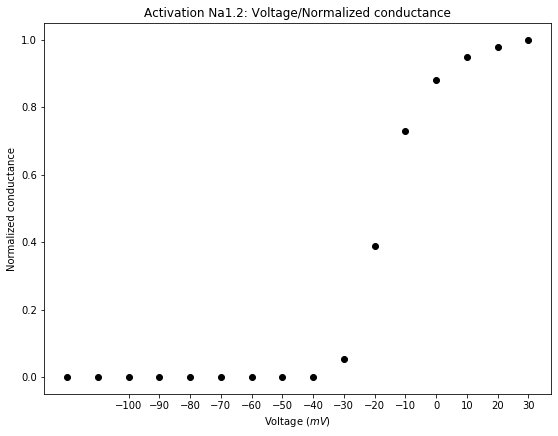

[Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343],
 Vector[343]]

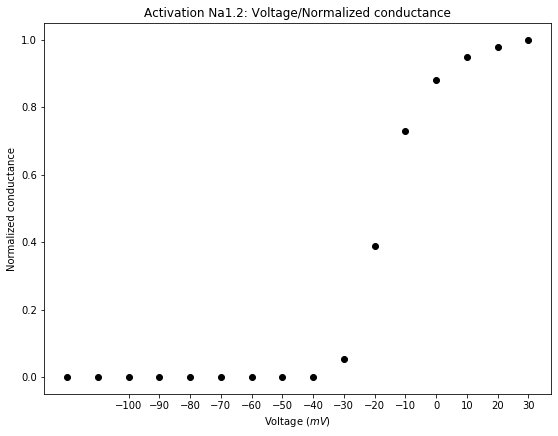

[Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350],
 Vector[350]]

(Vector[360],
 array([-120, -110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,
         -10,    0,   10,   20,   30]),
 [[3.0826776271615855e-12,
   -1.838780279018784e-12,
   2.1604584861100722e-12,
   2.3031421393134475e-12,
   -4.121266068365264e-14,
   2.4693683049315097e-12,
   -1.0530837796867712e-12,
   -9.095654074541344e-13,
   -9.045919932647796e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.0

<TopLevelHocInterpreter>

In [24]:
# testing
display(activationNa12("plotActivation"));

display(activationNa12("plotActivation", \
                  soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                  channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                  dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                  f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120, \
                  x_axis_min=-100, x_axis_max=40, x_axis_step=10));

display(activationNa12("genActivation"));


display(activationNa12("geth"));



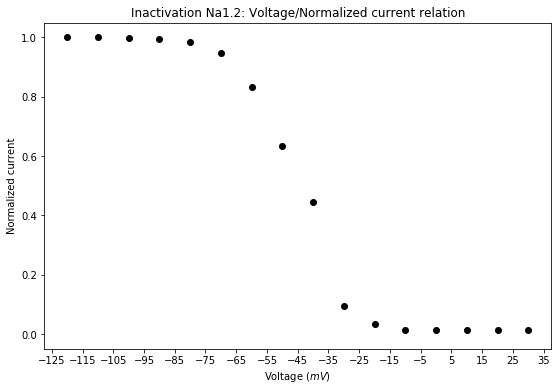

None

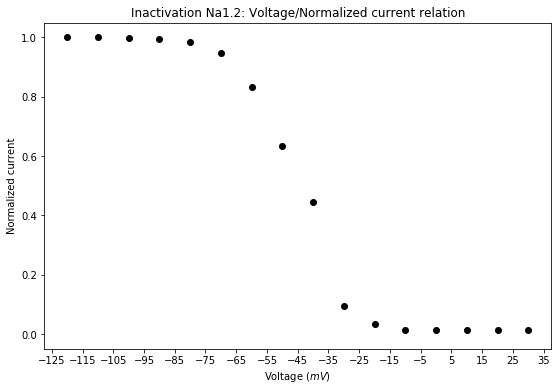

None

(Vector[491],
 array([-120, -110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,
         -10,    0,   10,   20,   30]),
 [[3.0826776271615855e-12,
   -1.838780279018784e-12,
   2.1604584861100722e-12,
   2.3031421393134475e-12,
   -4.121266068365264e-14,
   2.4693683049315097e-12,
   -1.0530837796867712e-12,
   -9.095654074541344e-13,
   -9.045919932647796e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.0

(Vector[497],
 array([-120, -110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,
         -10,    0,   10,   20,   30]),
 [[3.0826776271615855e-12,
   -1.838780279018784e-12,
   2.1604584861100722e-12,
   2.3031421393134475e-12,
   -4.121266068365264e-14,
   2.4693683049315097e-12,
   -1.0530837796867712e-12,
   -9.095654074541344e-13,
   -9.045919932647796e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.040236080441652e-13,
   -9.0

In [28]:
display(inactivationNa12("plotInactivation"))

display(inactivationNa12("plotInactivation", \
                    soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                    channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                    dur=500, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                    f3cl_dur0=40, f3cl_amp0=-120, f3cl_dur2=20, f3cl_amp2=-10, \
                    x_axis_min=-125, x_axis_max=40, x_axis_step=10));


display(inactivationNa12("genInactivation"))

display(inactivationNa12("genInactivation", \
                    soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                    channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                    dur=500, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                    f3cl_dur0=40, f3cl_amp0=-120, f3cl_dur2=20, f3cl_amp2=-10, \
                    x_axis_min=-125, x_axis_max=40, x_axis_step=10));



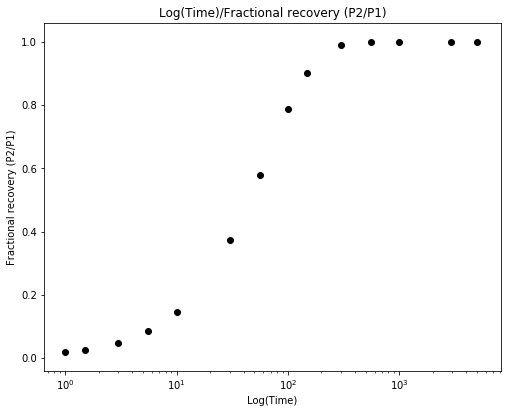

None

Vector[511]

([0.01839831482717915,
  0.025911726736695166,
  0.048106813556044584,
  0.08538050636566206,
  0.1454540558163688,
  0.37261745472085783,
  0.5801745055240569,
  0.7872727598946047,
  0.9017535178190892,
  0.9903216719737425,
  0.9998257252148324,
  0.9999997792159644,
  0.9999999736254565,
  0.9999999736254565],
 [1, 1.5, 3, 5.6, 10, 30, 56, 100, 150, 300, 560, 1000, 2930, 5000])

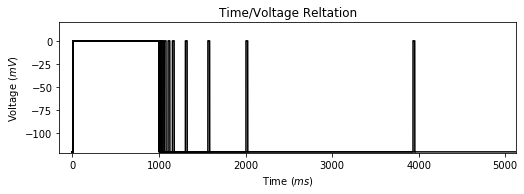

None

([0.01839831482717915,
  0.025911726736695166,
  0.048106813556044584,
  0.08538050636566206,
  0.1454540558163688,
  0.37261745472085783,
  0.5801745055240569,
  0.7872727598946047,
  0.9017535178190892,
  0.9903216719737425,
  0.9998257252148324,
  0.9999997792159644,
  0.9999999736254565,
  0.9999999736254565],
 [1, 1.5, 3, 5.6, 10, 30, 56, 100, 150, 300, 560, 1000, 2930, 5000])

([0.01839831482717915,
  0.025911726736695166,
  0.048106813556044584,
  0.08538050636566206,
  0.1454540558163688,
  0.37261745472085783,
  0.5801745055240569,
  0.7872727598946047,
  0.9017535178190892,
  0.9903216719737425,
  0.9998257252148324,
  0.9999997792159644,
  0.9999999736254565,
  0.9999999736254565],
 [1, 1.5, 3, 5.6, 10, 30, 56, 100, 150, 300, 560, 1000, 2930, 5000])

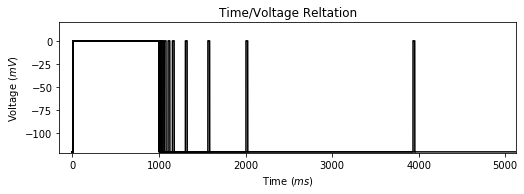

None

([0.01839831482717915,
  0.025911726736695166,
  0.048106813556044584,
  0.08538050636566206,
  0.1454540558163688,
  0.37261745472085783,
  0.5801745055240569,
  0.7872727598946047,
  0.9017535178190892,
  0.9903216719737425,
  0.9998257252148324,
  0.9999997792159644,
  0.9999999736254565,
  0.9999999736254565],
 [1, 1.5, 3, 5.6, 10, 30, 56, 100, 150, 300, 560, 1000, 2930, 5000])

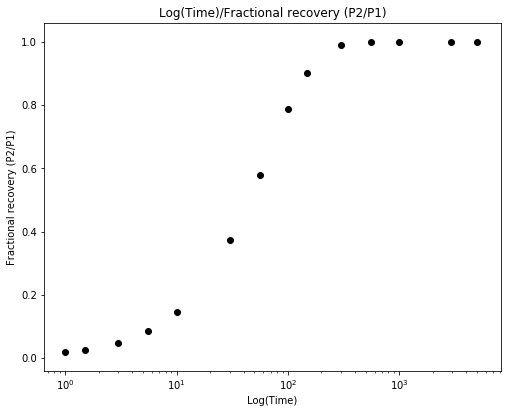

None

Vector[567]

In [30]:
display(recInactTauNa12("plotRecInact", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120));

display(recInactTauNa12("genRecInactTau", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))

display(recInactTauNa12("genRecInactTauCurve", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))


display(recInactTauNa12("plotRecInactProcedure", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120));


display(recInactTauNa12("genRecInact", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))



display(recInactTauNa12("genRecInact"));

display(recInactTauNa12("plotRecInactProcedure"));

display(recInactTauNa12("genRecInactTauCurve"));

display(recInactTauNa12("plotRecInact"));

display(recInactTauNa12("genRecInactTau"));

In [2]:
display(recInact_dv_TauNa12("genRecInactTaudv"));

display(recInact_dv_TauNa12("genRecInactTauCurvedv"));

display(recInact_dv_TauNa12("genRecInact"));

display(recInact_dv_TauNa12("genRecInactTaudv", \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.01,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1, res_pot=-120, dur=0.1,\
                   vec_pts = np.linspace(-120,0,num=13),\
                   f3cl_dur0=50, f3cl_amp0=-120, f3cl_dur1=5, f3cl_amp1=0, f3cl_dur2=1, \
                   f3cl_dur3=5, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))

display(recInact_dv_TauNa12("genRecInactTauCurvedv", \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.01,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1, res_pot=-120, dur=0.1,\
                   vec_pts = np.linspace(-120,0,num=13),\
                   f3cl_dur0=50, f3cl_amp0=-120, f3cl_dur1=5, f3cl_amp1=0, f3cl_dur2=1, \
                   f3cl_dur3=5, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))

display(recInact_dv_TauNa12("genRecInact", \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.01,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1, res_pot=-120, dur=0.1,\
                   vec_pts = np.linspace(-120,0,num=13),\
                   f3cl_dur0=50, f3cl_amp0=-120, f3cl_dur1=5, f3cl_amp1=0, f3cl_dur2=1, \
                   f3cl_dur3=5, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))

C:\Users\emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:830: RuntimeWarning: divide by zero encountered in log


(Vector[9],
 [[6.110501373553928e-12,
   -5.596377175695263e-13,
   6.417308796327175e-13,
   3.500012876810591e-12,
   -2.7463326830941178e-12,
   2.7529399747396435e-12,
   -1.6058068778286655e-12,
   2.103941370800964e-12,
   -2.577357447466834e-13,
   2.0516554977386294e-13,
   2.4438000447280363e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.5006329368472

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 array([-120., -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,
         -30.,  -20.,  -10.,    0.]))

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 array([-120., -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,
         -30.,  -20.,  -10.,    0.]))

(Vector[30],
 [[6.110501373553928e-12,
   -5.596377175695263e-13,
   6.417308796327175e-13,
   3.500012876810591e-12,
   -2.7463326830941178e-12,
   2.7529399747396435e-12,
   -1.6058068778286655e-12,
   2.103941370800964e-12,
   -2.577357447466834e-13,
   2.0516554977386294e-13,
   2.4438000447280363e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.50063293684727e-13,
   2.500632936847

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 array([-120., -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,
         -30.,  -20.,  -10.,    0.]))

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 array([-120., -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,
         -30.,  -20.,  -10.,    0.]))